<a href="https://colab.research.google.com/github/quynhu-d/TTS_HiFiGAN/blob/master/overfit_hifigan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%load_ext autoreload
%autoreload 2

# Cloning and imports

In [1]:
!git clone https://github.com/quynhu-d/TTS_HiFiGAN/

Cloning into 'TTS_HiFiGAN'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 58 (delta 17), reused 51 (delta 12), pack-reused 0
Unpacking objects: 100% (58/58), done.


In [2]:
%cd TTS_HiFiGAN/

/content/TTS_HiFiGAN


In [ ]:
!pip install -r ./requirements.txt

In [4]:
from torchvision import transforms, datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [5]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [6]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Data

In [ ]:
# !wget https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2
# !tar -xjf LJSpeech-1.1.tar.bz2 -C "/content/drive/MyDrive/TTS/"

In [ ]:
from data import *

In [ ]:
lj_path = '/content/drive/MyDrive/TTS/'
dataset = LJSpeechDataset(lj_path)

In [ ]:
train_dataloader = DataLoader(dataset, batch_size=3, collate_fn=LJSpeechCollator(), shuffle=False)

In [ ]:
iter(train_dataloader)

In [ ]:
(iter(train_dataloader)).next()

Batch(waveform=tensor([[-0.0078, -0.0138, -0.0172,  ...,  0.0012,  0.0013,  0.0015],
        [-0.0089, -0.0077, -0.0077,  ...,  0.0204,  0.0449,  0.0652],
        [ 0.0867,  0.1351,  0.1901,  ..., -0.3068,  0.0231,  0.2711]]), waveform_length=tensor([212893,  41885, 213149], dtype=torch.int32), transcript=('Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition', 'in being comparatively modern.', 'For although the Chinese took impressions from wood blocks engraved in relief for centuries before the woodcutters of the Netherlands, by a similar process'), mel=None)

In [ ]:
waveform = next(iter(dataset))[0]

In [ ]:
segment_size = 8192
new_waveforms = []
for waveform_ in torch.stack([waveform] * 3):
    waveform_ = waveform_.squeeze(0)
    if waveform_.size(0) >= segment_size:
        max_audio_start = waveform_.size(0) - segment_size
        audio_start = np.random.randint(0, max_audio_start)
        waveform_ = waveform_[audio_start:audio_start+segment_size]
    else:
        waveform_ = torch.nn.functional.pad(waveform_, (0, segment_size - waveform_.size(0)), 'constant')
    new_waveforms.append(waveform_)
torch.stack(new_waveforms).shape

torch.Size([3, 8192])

In [ ]:
waveform.shape

torch.Size([1, 212893])

# Mel

In [ ]:
from featurizer import *

In [ ]:
batch = (iter(train_dataloader)).next()
batch

Batch(waveform=tensor([[-0.0813, -0.0989, -0.1166,  ...,  0.1069,  0.1168,  0.1346],
        [-0.0078, -0.0072, -0.0067,  ...,  0.0869,  0.0853,  0.0835],
        [-0.1348, -0.0853,  0.2620,  ...,  0.0012,  0.0025,  0.0036]]), waveform_length=tensor([212893,  41885, 213149], dtype=torch.int32), transcript=('Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition', 'in being comparatively modern.', 'For although the Chinese took impressions from wood blocks engraved in relief for centuries before the woodcutters of the Netherlands, by a similar process'), durations=None, duration_preds=None)

In [ ]:
mel = MelSpectrogram(MelSpectrogramConfig())

In [ ]:
mel(batch.waveform).shape

torch.Size([3, 80, 33])

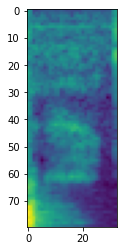

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(mel(batch.waveform)[2])

# Model

In [ ]:
from torchsummary import summary

## Generator

In [ ]:
from models import Generator

In [ ]:
gen = Generator(80, 128)
summary(gen, (80,400))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 128, 400]          71,808
         LeakyReLU-2             [-1, 128, 400]               0
   ConvTranspose1d-3             [-1, 64, 3200]         131,136
            Conv1d-4             [-1, 64, 3200]          12,352
            Conv1d-5             [-1, 64, 3200]          12,352
            Conv1d-6             [-1, 64, 3200]          12,352
            Conv1d-7             [-1, 64, 3200]          12,352
            Conv1d-8             [-1, 64, 3200]          12,352
            Conv1d-9             [-1, 64, 3200]          12,352
         ResBlock-10             [-1, 64, 3200]               0
           Conv1d-11             [-1, 64, 3200]          28,736
           Conv1d-12             [-1, 64, 3200]          28,736
           Conv1d-13             [-1, 64, 3200]          28,736
           Conv1d-14             [-1, 6

In [ ]:
Generator(80,128)(mel(next(iter(train_dataloader)).waveform)).shape

torch.Size([3, 8448])

# Overfit Generator

In [ ]:
batch = next(iter(train_dataloader))

In [ ]:
import torch.nn.functional as F
from models import Generator
import numpy as np
import torch
torch.autograd.set_detect_anomaly(True)
from tqdm.auto import tqdm, trange
from torchvision.transforms import ToTensor
import PIL
from trainer.utils import plot_spectrogram_to_buf
from featurizer import *
from data import *


LOG = True
RGB = True
display_step = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Generator(80, 512).to(device)
model.train()
lj_path = '/content/drive/MyDrive/TTS/'
dataset = LJSpeechDataset(lj_path)
train_dataloader = DataLoader(dataset, batch_size=4, collate_fn=LJSpeechCollator(), shuffle=False)
batch = next(iter(train_dataloader))
print(model)
opt_g = torch.optim.AdamW(model.parameters(), 2e-4, (.8,.99), weight_decay=.01)
sch_g = torch.optim.lr_scheduler.ExponentialLR(opt_g, gamma=.999, last_epoch=-1)
n_epochs = 10000
if LOG:
    wandb.init(project='TTS_HiFiGAN', name='overfit_generator_gpu_4')
featurizer = MelSpectrogram(MelSpectrogramConfig()).to(device)
for i in trange(n_epochs):
    for _ in train_dataloader:    # fixed batch above
        batch.to(device)
        opt_g.zero_grad()
        batch.mel = featurizer(batch.waveform).to(device)
        pred_wav = model(batch.mel)
        # print(pred_wav.size(), batch.mel.size())
        # print(featurizer(pred_wav).shape)

        sz_diff = np.abs(batch.waveform.size(-1) - pred_wav.size(-1))    
        if sz_diff != 0:    
            if batch.waveform.size(-1) > pred_wav.size(-1):
                # print('padding waveform')
                pred_wav = F.pad(pred_wav, (0, sz_diff))
                true_wav = batch.waveform
            else:
                # print('padding batch')
                true_wav = F.pad(batch.waveform, (0, sz_diff))
            # batch.mel = featurizer(batch.waveform)
        # print(batch.waveform.shape, pred_wav.shape)
        assert true_wav.shape == pred_wav.shape
        pred_mel = featurizer(pred_wav)
        mel_loss = F.l1_loss(pred_mel, featurizer(true_wav)) * 45
        mel_loss.backward()
        opt_g.step()
        # break

        idx = np.random.randint(batch.mel.shape[0])
        if LOG and ((i % display_step) == 0):
            if RGB:
                buf_true = plot_spectrogram_to_buf(batch.mel[idx].detach().cpu().numpy())
                buf_pred = plot_spectrogram_to_buf(pred_mel[idx].detach().cpu().numpy())
                wandb_mel_true = ToTensor()(PIL.Image.open(buf_true))
                wandb_mel_pred = ToTensor()(PIL.Image.open(buf_pred))
                del buf_pred
                del buf_true
            else:
                wandb_mel_true = batch.mel[idx].detach().cpu().numpy()
                wandb_mel_pred = pred_mel[idx].detach().cpu().numpy()
            wandb.log({
                'mel_loss': mel_loss,
                'mel': wandb.Image(wandb_mel_true),
                'mel_pred': wandb.Image(wandb_mel_pred),
                'audio': wandb.Audio(batch.waveform[idx].detach().cpu().numpy(),
                                        sample_rate=MelSpectrogramConfig.sr),
                'audio_pred': wandb.Audio(pred_wav[idx].detach().cpu().numpy(),
                                            sample_rate=MelSpectrogramConfig.sr),
                'step': i
            })
        break
    sch_g.step()

wandb: Currently logged in as: quynhu_d (use `wandb login --relogin` to force relogin)


Generator(
  (conv_in): Conv1d(80, 512, kernel_size=(7,), stride=(1,), padding=(3,))
  (upsample_layers): Sequential(
    (0): LeakyReLU(negative_slope=0.1)
    (1): ConvTranspose1d(512, 256, kernel_size=(16,), stride=(8,), padding=(4,))
    (2): MRFModule(
      (resblocks): ModuleList(
        (0): ResBlock(
          (conv1): ModuleList(
            (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
            (1): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(3,), dilation=(3,))
            (2): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(5,), dilation=(5,))
          )
          (conv2): ModuleList(
            (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
            (1): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
            (2): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
          )
        )
        (1): ResBlock(
          (conv1): ModuleList(
            (0): Conv1d(256, 256, 

  0%|          | 0/10000 [00:00<?, ?it/s]